In [1]:
from train import get_grnti1_2_BERT_dataframes, get_grnti1_BERT_dataframes, prepair_datasets,\
prepair_model, prepair_compute_metrics, save_parameters, CustomTrainer, test_predictons,\
prepair_test_dataset, get_grnti1_BERT_dataframes
from peft import PeftConfig, PeftModel

from prediction import prepair_data_level2
from prediction import prepair_model as prepair_model_test
from prediction import prepair_dataset, make_predictions
from transformers import TrainingArguments
import os
import random
import numpy as np
import torch
import re
import pandas as pd
from tqdm.notebook import tqdm

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
path_to_dataset = "../datasets/base/ru/raw"

In [3]:
data_sokr = pd.read_csv('sokrlist.txt', encoding="cp1251", sep="\t")

In [4]:
data_sokr_dict  = dict(zip(data_sokr.short_str, data_sokr.full_str))

In [5]:
# SEED = 12345
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)

### Train level 1 correct

In [6]:
def clear_text(text):
    # Удалить формулы внутри $$...$$
    text = re.sub(r'\$\$.*?\$\$', '', text, flags=re.DOTALL)
    # Удалить формулы внутри $...$
    text = re.sub(r'\$.*?\$', '', text, flags=re.DOTALL)
    # Удалить формулы внутри \[...\] или \(...\)
    text = re.sub(r'\\\[.*?\\\]', '', text, flags=re.DOTALL)
    # Удалить окружения формул (\begin{...}...\end{...})
    text = re.sub(r'\\begin\{.*?\}.*?\\end\{.*?\}', '', text, flags=re.DOTALL)
    # Ссылки
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # Удаляем элементы в скобках <>
    text = re.sub('<.*?>+', '', text)
    # Перенос строки
    text = re.sub('\n', '', text)
    # Число посреди слова
    text = re.sub('\w*\d\w*', '', text)
    return text

In [7]:
max_number_tokens = 512
pre_trained_model_name ='DeepPavlov/rubert-base-cased'
r = 16
lora_alpha = 16
lora_dropout = 0.05

In [8]:
base_name = "results_8_lora_sokr_experiment/"
number_of_delteted_values = 15
minimal_number_of_elements_RGNTI2 = 1
minimal_number_of_words = 10

path_info_before_save = base_name + f"data_info_from_bert_level1/"

In [9]:
epoch= 10
batch_size=8
weight_decay = 1e-6
warmup_steps = 10
fp16 = True
optim = "adamw_bnb_8bit"


Удаление элементов второго уровня, количство которых меньше 1
         id_publ                                              title  \
0   19.06-73.269  Некоторые аспекты изменения степных ландшафтов...   
1   19.01-24А.85  Подходы к повышению точности определения харак...   
2   19.06-66.105  Микроскопическое моделирование фазового поля п...   
3   19.06-14Б.10  МОДЕЛИ И МЕТОДИКИ АВТОМАТИЗАЦИИ ПРОЦЕДУР РАЗРА...   
4  19.10-19Ж.456  Трехкомпонентная реакция Кастагноли-Кушмана 3-...   

                                             ref_txt  \
0  Предлагается результат анализа динамики некото...   
1  В статье представлены подходы к повышению точн...   
2  Процесс выделения сплава Ni[75]Al[15]Ti[10] мо...   
3  Объектом исследования является проектирование ...   
4  Попытки использования 3-арилглутаконовых кисло...   

                                             kw_list   SUBJ     IPV  \
0  Урало-Заволжье\анализ динамики\ландшафты\нефте...  f3\e2   72\73   
1  метровый диапазон\обнаружение

100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Доля оставшихся элементов в тренировочном датасете:  0.9715610583770008


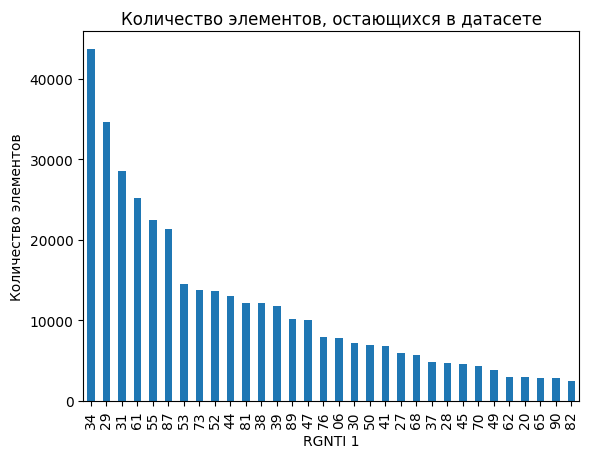

In [10]:
if not os.path.exists(path_info_before_save):
    os.makedirs(path_info_before_save)
df, df_test, n_classes, n_classes2 = get_grnti1_BERT_dataframes(path_to_dataset, 
                                            number_of_delteted_values=number_of_delteted_values, 
                                minimal_number_of_elements_RGNTI2=minimal_number_of_elements_RGNTI2,
                                minimal_number_of_words=minimal_number_of_words,
                                dir_name=path_info_before_save, grnti_folder="grnti_dicts_level1_v2/",
                                change_codes=False)

In [11]:
df.shape

(285159, 13)

In [12]:
n_classes

32

In [13]:
df['text'] = df['text'].progress_apply(clear_text)

  0%|          | 0/285159 [00:00<?, ?it/s]

In [14]:
df_test['text'] = df_test['text'].progress_apply(clear_text)

  0%|          | 0/166183 [00:00<?, ?it/s]

In [15]:
import string

# Базовые символы из модуля string
delimiters = set(string.punctuation)
# whitespace_list = list(string.whitespace)
# Дополнительные символы, которые могут быть разделителями
additional_delimiters = {"|", "/", "\\", "-", "_", ".", "*", "+", "=", "&", "%", "$", "#", "@", "!", "?", "~", "^", "(", ")", "[", "]", "{", "}", "<", ">", "'", '"', "`"}

# Объединяем все символы
all_delimiters = delimiters.union(additional_delimiters)

In [16]:
def get_word_parts(input_string, delimiters):
    # 
    word_start = ""
    word_finish = ""

    # Проверяем, есть ли строка из сета слева
    for delim in delimiters:
        if input_string.startswith(delim):
            word_start +=  delim
            input_string = input_string[len(delim):]
        
    # Проверяем, есть ли строка из сета справа

        if input_string.endswith(delim):
            # Если найдено, возвращаем оставшуюся часть строки
            input_string = input_string[:-len(delim)]
            word_finish += delim
        
    return word_start, input_string, word_finish



In [17]:
# !pip3 install pandas jupyter

In [18]:
def aug_for_sokr(text, sokr_kind, data_sokr_dict, delimiters):
    result_text_list = []
    for input_string in text.split(): 
        word_start, input_string, word_finish = get_word_parts(input_string, delimiters)

        # if input_string in data_sokr_dict:
        result_text_list.append(data_sokr_dict[input_string] + " " +
                                word_start + input_string + word_finish
                                if input_string in data_sokr_dict and sokr_kind=="append_sokr"
                                else word_start + data_sokr_dict[input_string] + word_finish
                                if input_string in data_sokr_dict and sokr_kind=="rename_sokr"
                                else word_start + input_string + word_finish
                                )
    return " ".join(result_text_list)


In [19]:
aug_for_sokr("вообще, .ЭЦ, это очень важно",
                          sokr_kind = "rename_sokr",
                          data_sokr_dict = data_sokr_dict,
                          delimiters=delimiters)

'вообще, .электрическая централизация, это очень важно'

In [20]:
compute_metrics = prepair_compute_metrics(n_classes=n_classes)

In [21]:
dir_name = base_name + "model bert lora level 1/"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

In [22]:
save_parameters(dir_name = dir_name, 
                number_of_delteted_values = number_of_delteted_values, 
                minimal_number_of_elements_RGNTI2= minimal_number_of_elements_RGNTI2,
                minimal_number_of_words = minimal_number_of_words, 
                max_number_tokens= max_number_tokens, 
                pre_trained_model_name= pre_trained_model_name,
                r=r, 
                lora_alpha= lora_alpha, lora_dropout = lora_dropout,
                epoch= epoch, 
                batch_size= batch_size,
                weight_decay= weight_decay,
                warmup_steps= warmup_steps,
                fp16=fp16, 
                optim= optim)

In [23]:
def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
df_old_text = df["text"].copy()
df_test_old_text = df_test["text"].copy()

for sokr_kind in tqdm(["no_sokr"],#"rename_sokr", "append_sokr", "no_sokr"
                      leave=True, desc="sokr_kind", total=1):
    

    SEED = 12345
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    


    df['text'] = df_old_text.progress_apply(aug_for_sokr,
                          sokr_kind = sokr_kind,
                          data_sokr_dict = data_sokr_dict,
                          delimiters=delimiters,
                          )
    df_test['text'] = df_test_old_text.progress_apply(aug_for_sokr,
                          sokr_kind = sokr_kind,
                          data_sokr_dict = data_sokr_dict,
                          delimiters=delimiters,
                          )
    
    train_dataset, validation_dataset, test_dataset,\
    tokenizer, collate_fn, class_weights = prepair_datasets(df, df_test,
                                                            n_classes, 
                                                            level = '',
                                                            max_number_tokens=max_number_tokens, 
                                                            pre_trained_model_name=pre_trained_model_name)

    model = prepair_model(n_classes=n_classes, 
                            pre_trained_model_name=pre_trained_model_name,
                            r=r, lora_alpha=lora_alpha, 
                            lora_dropout=lora_dropout)

    dir_name_new = dir_name + sokr_kind + "/"
    if not os.path.exists(dir_name_new):
        os.makedirs(dir_name_new)


    training_args = TrainingArguments(
        output_dir=dir_name_new,          
        num_train_epochs=epoch,
        warmup_steps=warmup_steps,
        logging_dir=dir_name_new,
        weight_decay=weight_decay,
        eval_strategy='epoch',
        save_strategy= "epoch",
        logging_strategy="steps",
        logging_steps = 100,
        load_best_model_at_end=True,
        save_total_limit=1,
        report_to='tensorboard',
        overwrite_output_dir = False,
        save_safetensors = False,
        fp16=fp16,
        optim = optim,
        per_device_train_batch_size= batch_size,
        per_device_eval_batch_size= batch_size,
        group_by_length=True,
        dataloader_num_workers = 1,
        metric_for_best_model="eval_f1_weighted_0.5",
        )
    train_dataset = train_dataset.remove_columns("text")
    validation_dataset = validation_dataset.remove_columns(["text", "__index_level_0__"])

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=validation_dataset,
        data_collator = collate_fn,
        tokenizer = tokenizer,
        compute_metrics=compute_metrics,
        class_weights=class_weights,
    )

    trainer.train()
    trainer.model.save_pretrained(dir_name_new + "bert_peft_level1_lora")

    #______________________________________________________________________
    test_dataset = test_dataset.remove_columns(["text", "__index_level_0__"])

    predict_res = trainer.predict(test_dataset=test_dataset).predictions

    with open(dir_name_new + "trainer_predictions_level1_lora.npy", 'wb') as f:
        np.save(f, predict_res)

    with open(dir_name_new + "trainer_predictions_level1_lora.npy", 'rb') as f:

        prediction1_experiment = np.load(f)

    label_test = np.vstack(df_test["target_coded"])


    if not os.path.exists(path_info_before_save + sokr_kind + "/"):
        os.makedirs(path_info_before_save + sokr_kind + "/")

    test_predictons(sigmoid_array(prediction1_experiment),
                    label_test,
                    path_info_before_save + sokr_kind + "/",
                    n_classes,  
                    level=1,
                    grnti_path="grnti_dicts_level1_v2/")



sokr_kind:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/285159 [00:00<?, ?it/s]

  0%|          | 0/166183 [00:00<?, ?it/s]

Веса для кажого класса:  tensor([1.3164, 1.2443, 1.5663, 0.6472, 3.6027, 0.2040, 3.0185, 1.4897, 3.1646,
        0.8802, 1.2860, 2.2852, 0.4165, 0.3968, 1.1249, 0.3536, 1.9390, 0.7354,
        1.8193, 0.3115, 0.8897, 0.2691, 0.6810, 0.6133, 0.6533, 0.7356, 2.0284,
        0.7524, 1.9058, 3.0932, 1.1319, 3.0083], dtype=torch.float64)
Подготовка тренировочных данных:


Map:   0%|          | 0/228152 [00:00<?, ? examples/s]

Подготовка валидационных данных:


Map:   0%|          | 0/57007 [00:00<?, ? examples/s]

Подготовка тестовых данных:


Map:   0%|          | 0/166183 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

  0%|          | 0/285190 [00:00<?, ?it/s]

c:\Users\victo\git_Work_VINITI_2024\my_venv_cuda\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 0.4621, 'grad_norm': 0.3252200484275818, 'learning_rate': 4.9984220492320644e-05, 'epoch': 0.0}
{'loss': 0.146, 'grad_norm': 0.2684568166732788, 'learning_rate': 4.996668770601024e-05, 'epoch': 0.01}
{'loss': 0.1411, 'grad_norm': 0.29005166888237, 'learning_rate': 4.994915491969984e-05, 'epoch': 0.01}
{'loss': 0.1351, 'grad_norm': 0.36735931038856506, 'learning_rate': 4.9931622133389436e-05, 'epoch': 0.01}
{'loss': 0.1301, 'grad_norm': 0.20821887254714966, 'learning_rate': 4.991408934707904e-05, 'epoch': 0.02}
{'loss': 0.1151, 'grad_norm': 0.40477466583251953, 'learning_rate': 4.989655656076864e-05, 'epoch': 0.02}
{'loss': 0.1046, 'grad_norm': 0.18585632741451263, 'learning_rate': 4.987902377445824e-05, 'epoch': 0.02}
{'loss': 0.0997, 'grad_norm': 0.3082806169986725, 'learning_rate': 4.986149098814784e-05, 'epoch': 0.03}
{'loss': 0.0932, 'grad_norm': 0.28870436549186707, 'learning_rate': 4.984395820183744e-05, 'epoch': 0.03}
{'loss': 0.0951, 'grad_norm': 0.2358158528804779, 'l

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.039590176194906235, 'eval_accuracy_micro_0.5': 0.9827159643173218, 'eval_accuracy_macro_0.5': 0.9827159643173218, 'eval_accuracy_weighted_0.5': 0.9744453430175781, 'eval_f1_micro_0.5': 0.7737449407577515, 'eval_f1_macro_0.5': 0.7384516000747681, 'eval_f1_weighted_0.5': 0.7670003175735474, 'eval_f1_micro_0.6': 0.7585615515708923, 'eval_f1_macro_0.6': 0.717097818851471, 'eval_f1_weighted_0.6': 0.7474473714828491, 'eval_f1_micro_0.7': 0.7293698191642761, 'eval_f1_macro_0.7': 0.6819088459014893, 'eval_f1_weighted_0.7': 0.7126409411430359, 'eval_f1_micro_0.8': 0.6763807535171509, 'eval_f1_macro_0.8': 0.4952981472015381, 'eval_f1_weighted_0.8': 0.5255935192108154, 'eval_f1_micro_0.9': 0.5614122152328491, 'eval_aucroc_micro': 0.9185224771499634, 'eval_aucroc_macro': 0.9059772491455078, 'eval_aucroc_weighted': 0.9158555865287781, 'eval_runtime': 1916.3052, 'eval_samples_per_second': 29.748, 'eval_steps_per_second': 3.719, 'epoch': 1.0}
{'loss': 0.0377, 'grad_norm': 0.2696458399

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.035133246332407, 'eval_accuracy_micro_0.5': 0.9847195148468018, 'eval_accuracy_macro_0.5': 0.9847195148468018, 'eval_accuracy_weighted_0.5': 0.9776033163070679, 'eval_f1_micro_0.5': 0.8072468042373657, 'eval_f1_macro_0.5': 0.7867873311042786, 'eval_f1_weighted_0.5': 0.8051298260688782, 'eval_f1_micro_0.6': 0.7997735142707825, 'eval_f1_macro_0.6': 0.7773063778877258, 'eval_f1_weighted_0.6': 0.794736385345459, 'eval_f1_micro_0.7': 0.7827870845794678, 'eval_f1_macro_0.7': 0.7554120421409607, 'eval_f1_weighted_0.7': 0.7738250494003296, 'eval_f1_micro_0.8': 0.7447208166122437, 'eval_f1_macro_0.8': 0.616360604763031, 'eval_f1_weighted_0.8': 0.6337466239929199, 'eval_f1_micro_0.9': 0.6602672338485718, 'eval_aucroc_micro': 0.936499834060669, 'eval_aucroc_macro': 0.9298807382583618, 'eval_aucroc_weighted': 0.934124231338501, 'eval_runtime': 1847.5504, 'eval_samples_per_second': 30.855, 'eval_steps_per_second': 3.857, 'epoch': 2.0}
{'loss': 0.0357, 'grad_norm': 0.1529205441474914

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.032804228365421295, 'eval_accuracy_micro_0.5': 0.985800564289093, 'eval_accuracy_macro_0.5': 0.9858005046844482, 'eval_accuracy_weighted_0.5': 0.9792070388793945, 'eval_f1_micro_0.5': 0.8203139901161194, 'eval_f1_macro_0.5': 0.802146852016449, 'eval_f1_weighted_0.5': 0.8184311389923096, 'eval_f1_micro_0.6': 0.8141055107116699, 'eval_f1_macro_0.6': 0.7952490448951721, 'eval_f1_weighted_0.6': 0.8097255229949951, 'eval_f1_micro_0.7': 0.7958633303642273, 'eval_f1_macro_0.7': 0.775359570980072, 'eval_f1_weighted_0.7': 0.7881708741188049, 'eval_f1_micro_0.8': 0.7589312195777893, 'eval_f1_macro_0.8': 0.6475613713264465, 'eval_f1_weighted_0.8': 0.6531468629837036, 'eval_f1_micro_0.9': 0.677144467830658, 'eval_aucroc_micro': 0.9411326050758362, 'eval_aucroc_macro': 0.9363872408866882, 'eval_aucroc_weighted': 0.9392258524894714, 'eval_runtime': 2230.7498, 'eval_samples_per_second': 25.555, 'eval_steps_per_second': 3.194, 'epoch': 3.0}
{'loss': 0.037, 'grad_norm': 0.27515226602554

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.03089595027267933, 'eval_accuracy_micro_0.5': 0.9865010976791382, 'eval_accuracy_macro_0.5': 0.9865010976791382, 'eval_accuracy_weighted_0.5': 0.9801609516143799, 'eval_f1_micro_0.5': 0.8302204012870789, 'eval_f1_macro_0.5': 0.8133281469345093, 'eval_f1_weighted_0.5': 0.8280794620513916, 'eval_f1_micro_0.6': 0.8255608081817627, 'eval_f1_macro_0.6': 0.8070688843727112, 'eval_f1_weighted_0.6': 0.8212113380432129, 'eval_f1_micro_0.7': 0.8107051849365234, 'eval_f1_macro_0.7': 0.7889596819877625, 'eval_f1_weighted_0.7': 0.803196907043457, 'eval_f1_micro_0.8': 0.7811077237129211, 'eval_f1_macro_0.8': 0.6787113547325134, 'eval_f1_weighted_0.8': 0.6895345449447632, 'eval_f1_micro_0.9': 0.7116591334342957, 'eval_aucroc_micro': 0.943052351474762, 'eval_aucroc_macro': 0.9378416538238525, 'eval_aucroc_weighted': 0.9411738514900208, 'eval_runtime': 2295.51, 'eval_samples_per_second': 24.834, 'eval_steps_per_second': 3.104, 'epoch': 4.0}
{'loss': 0.0254, 'grad_norm': 0.15856285393238

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.029148399829864502, 'eval_accuracy_micro_0.5': 0.9871205687522888, 'eval_accuracy_macro_0.5': 0.9871205687522888, 'eval_accuracy_weighted_0.5': 0.9809685945510864, 'eval_f1_micro_0.5': 0.8365826606750488, 'eval_f1_macro_0.5': 0.8201292157173157, 'eval_f1_weighted_0.5': 0.8343986868858337, 'eval_f1_micro_0.6': 0.8301024436950684, 'eval_f1_macro_0.6': 0.8115653395652771, 'eval_f1_weighted_0.6': 0.8259772062301636, 'eval_f1_micro_0.7': 0.8134951591491699, 'eval_f1_macro_0.7': 0.7923589944839478, 'eval_f1_weighted_0.7': 0.8066452741622925, 'eval_f1_micro_0.8': 0.7811286449432373, 'eval_f1_macro_0.8': 0.6801872253417969, 'eval_f1_weighted_0.8': 0.6872411370277405, 'eval_f1_micro_0.9': 0.7070793509483337, 'eval_aucroc_micro': 0.9438704252243042, 'eval_aucroc_macro': 0.9377585649490356, 'eval_aucroc_weighted': 0.9421921372413635, 'eval_runtime': 2272.6244, 'eval_samples_per_second': 25.084, 'eval_steps_per_second': 3.136, 'epoch': 5.0}
{'loss': 0.0305, 'grad_norm': 0.118282049

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.028771257027983665, 'eval_accuracy_micro_0.5': 0.9873672127723694, 'eval_accuracy_macro_0.5': 0.9873672723770142, 'eval_accuracy_weighted_0.5': 0.9814383387565613, 'eval_f1_micro_0.5': 0.8414265513420105, 'eval_f1_macro_0.5': 0.8281469941139221, 'eval_f1_weighted_0.5': 0.8402511477470398, 'eval_f1_micro_0.6': 0.8368409276008606, 'eval_f1_macro_0.6': 0.8230135440826416, 'eval_f1_weighted_0.6': 0.8337116241455078, 'eval_f1_micro_0.7': 0.8236781358718872, 'eval_f1_macro_0.7': 0.8097596764564514, 'eval_f1_weighted_0.7': 0.8181269764900208, 'eval_f1_micro_0.8': 0.7952172160148621, 'eval_f1_macro_0.8': 0.713355541229248, 'eval_f1_weighted_0.8': 0.7126336693763733, 'eval_f1_micro_0.9': 0.7307760119438171, 'eval_aucroc_micro': 0.9477612972259521, 'eval_aucroc_macro': 0.9445883631706238, 'eval_aucroc_weighted': 0.9461402297019958, 'eval_runtime': 2185.3669, 'eval_samples_per_second': 26.086, 'eval_steps_per_second': 3.261, 'epoch': 6.0}
{'loss': 0.0264, 'grad_norm': 0.1146261990

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.02771061845123768, 'eval_accuracy_micro_0.5': 0.9877718091011047, 'eval_accuracy_macro_0.5': 0.9877718091011047, 'eval_accuracy_weighted_0.5': 0.9820284843444824, 'eval_f1_micro_0.5': 0.8452504277229309, 'eval_f1_macro_0.5': 0.8317253589630127, 'eval_f1_weighted_0.5': 0.843483567237854, 'eval_f1_micro_0.6': 0.8397219777107239, 'eval_f1_macro_0.6': 0.8256581425666809, 'eval_f1_weighted_0.6': 0.8361246585845947, 'eval_f1_micro_0.7': 0.8248072862625122, 'eval_f1_macro_0.7': 0.8101315498352051, 'eval_f1_weighted_0.7': 0.8187511563301086, 'eval_f1_micro_0.8': 0.7958317399024963, 'eval_f1_macro_0.8': 0.7117658257484436, 'eval_f1_weighted_0.8': 0.7125768661499023, 'eval_f1_micro_0.9': 0.7316765189170837, 'eval_aucroc_micro': 0.9466236233711243, 'eval_aucroc_macro': 0.9423802495002747, 'eval_aucroc_weighted': 0.9451125264167786, 'eval_runtime': 2224.923, 'eval_samples_per_second': 25.622, 'eval_steps_per_second': 3.203, 'epoch': 7.0}
{'loss': 0.0288, 'grad_norm': 0.249713569879

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.027210447937250137, 'eval_accuracy_micro_0.5': 0.9880086183547974, 'eval_accuracy_macro_0.5': 0.9880085587501526, 'eval_accuracy_weighted_0.5': 0.9823194742202759, 'eval_f1_micro_0.5': 0.8488011360168457, 'eval_f1_macro_0.5': 0.8354088068008423, 'eval_f1_weighted_0.5': 0.8472089767456055, 'eval_f1_micro_0.6': 0.8436235189437866, 'eval_f1_macro_0.6': 0.8292797803878784, 'eval_f1_weighted_0.6': 0.8403386473655701, 'eval_f1_micro_0.7': 0.8305039405822754, 'eval_f1_macro_0.7': 0.8149300217628479, 'eval_f1_weighted_0.7': 0.8248810172080994, 'eval_f1_micro_0.8': 0.8029400110244751, 'eval_f1_macro_0.8': 0.7169862985610962, 'eval_f1_weighted_0.8': 0.7221611738204956, 'eval_f1_micro_0.9': 0.7396284341812134, 'eval_aucroc_micro': 0.9485306739807129, 'eval_aucroc_macro': 0.9438804388046265, 'eval_aucroc_weighted': 0.9469943046569824, 'eval_runtime': 2181.4564, 'eval_samples_per_second': 26.133, 'eval_steps_per_second': 3.267, 'epoch': 8.0}
{'loss': 0.0273, 'grad_norm': 0.184060722

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.02675756998360157, 'eval_accuracy_micro_0.5': 0.9882092475891113, 'eval_accuracy_macro_0.5': 0.9882091879844666, 'eval_accuracy_weighted_0.5': 0.9826251268386841, 'eval_f1_micro_0.5': 0.85113126039505, 'eval_f1_macro_0.5': 0.8387589454650879, 'eval_f1_weighted_0.5': 0.8495029211044312, 'eval_f1_micro_0.6': 0.845373272895813, 'eval_f1_macro_0.6': 0.8323948979377747, 'eval_f1_weighted_0.6': 0.8420540690422058, 'eval_f1_micro_0.7': 0.8319131731987, 'eval_f1_macro_0.7': 0.8170965909957886, 'eval_f1_weighted_0.7': 0.8263146877288818, 'eval_f1_micro_0.8': 0.8039148449897766, 'eval_f1_macro_0.8': 0.721280038356781, 'eval_f1_weighted_0.8': 0.7236912846565247, 'eval_f1_micro_0.9': 0.7414059638977051, 'eval_aucroc_micro': 0.9487898349761963, 'eval_aucroc_macro': 0.9443429112434387, 'eval_aucroc_weighted': 0.9472783803939819, 'eval_runtime': 2123.4116, 'eval_samples_per_second': 26.847, 'eval_steps_per_second': 3.356, 'epoch': 9.0}
{'loss': 0.0242, 'grad_norm': 0.2682972848415375,

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.026783635839819908, 'eval_accuracy_micro_0.5': 0.988196611404419, 'eval_accuracy_macro_0.5': 0.988196611404419, 'eval_accuracy_weighted_0.5': 0.9826297760009766, 'eval_f1_micro_0.5': 0.8511626720428467, 'eval_f1_macro_0.5': 0.8385601043701172, 'eval_f1_weighted_0.5': 0.8495803475379944, 'eval_f1_micro_0.6': 0.8461373448371887, 'eval_f1_macro_0.6': 0.8329336643218994, 'eval_f1_weighted_0.6': 0.8428927063941956, 'eval_f1_micro_0.7': 0.8326174020767212, 'eval_f1_macro_0.7': 0.8178917169570923, 'eval_f1_weighted_0.7': 0.8270073533058167, 'eval_f1_micro_0.8': 0.8056230545043945, 'eval_f1_macro_0.8': 0.7240765690803528, 'eval_f1_weighted_0.8': 0.7262499332427979, 'eval_f1_micro_0.9': 0.7438410520553589, 'eval_aucroc_micro': 0.9493961930274963, 'eval_aucroc_macro': 0.9450067281723022, 'eval_aucroc_weighted': 0.947870135307312, 'eval_runtime': 2154.2099, 'eval_samples_per_second': 26.463, 'eval_steps_per_second': 3.308, 'epoch': 10.0}
{'train_runtime': 134932.9168, 'train_sampl

  0%|          | 0/20773 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:37<00:00,  2.09s/it]


Cтатистика количества пркдсказываемых классов при заданном threshold:
Среднее число предсказываемых классов для одной статьи, для которой получено предсказание tensor(1.2746)
Минимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(1)
Максимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(5)
Доля статей c пустым ответом классификатора (Empty): 0.03798222441525312
recall_micro_list threshold: [tensor(0.9463), tensor(0.9293), tensor(0.9139), tensor(0.8993), tensor(0.8852), tensor(0.8712), tensor(0.8570), tensor(0.8425), tensor(0.8272), tensor(0.8109), tensor(0.7936), tensor(0.7746), tensor(0.7529), tensor(0.7279), tensor(0.6967), tensor(0.6573), tensor(0.6016), tensor(0.5035)]
recall_macro_list threshold: [tensor(0.9361), tensor(0.9180), tensor(0.9016), tensor(0.8865), tensor(0.8721), tensor(0.8575), tensor(0.8435), tensor(0.8290), tensor(0.8141), tensor(0.7980), tensor(0.7812), tensor(0.7628), ten

100%|██████████| 18/18 [00:00<00:00, 67.26it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 3/3 [00:08<00:00,  2.86s/it]


Количество отказов от классификации (Reject) tensor(0)
Доля отказов от классификации (Reject) tensor(0.)
f1_top_k_macro [0.75 0.69 0.57]
f1_top_k_maicro [0.78 0.7  0.56]
f1_top_k_weighted [0.77 0.71 0.59]
precision_top_k_macro [0.86 0.57 0.42]
precision_top_k_maicro [0.88 0.57 0.4 ]
precision_top_k_weighted [0.88 0.6  0.44]
recall_top_k_macro: tensor([0.6910, 0.8871, 0.9447])
recall_top_k_micro: tensor([0.6988, 0.8987, 0.9533])
recall_top_k_weighted: tensor([0.6988, 0.8987, 0.9533])


<Figure size 640x480 with 0 Axes>